In [6]:
import sys, os
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from modules.io import read_json, write_json
from modules.dynamics import *
from matplotlib.lines import Line2D
red_line = Line2D([], [], color='r', lw=3, label='60622')

from modules.additional import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Read and preprocess raw data

In [7]:
# read locations
locations = pd.read_hdf('../chicago/data/data.hdf', 'locations')

# read preprocessed data (license history)
license_history = pd.read_hdf('../chicago/data/processed.hdf', 'licenses')
codebook = read_json('../chicago/data/license_codebook.json')
activitybook = read_json('../chicago/data/activity_codebook.json')

# load aggregate location data
location_history = pd.read_hdf('../chicago/data/processed.hdf', 'location_history')

# load property values
from modules.realestate import RealEstateData
mvalfah = pd.concat(RealEstateData('../chicago/realestate.hdf'), axis=1)

# SELECT DATA

In [8]:
#restaurants = location_history[location_history.CODES.apply(lambda x: '1006' in x)]
#data = restaurants.join(locations)

data = location_history.join(locations)

# ANALYSIS

In [9]:
original_locations = location_history[location_history.ORIGINAL]
new_locations = location_history[~location_history.ORIGINAL]

# total number of business in each zip at beginning of dataset
original_counts = original_locations.join(locations).groupby('ZIP')['ZIP'].count()

In [10]:
# define timebins
annual_bins = pd.date_range('01-01-2000', '10-31-2018', freq='1Y')
quarterly_bins = pd.date_range('10-01-2000', pd.Timestamp.today(), freq='3M')
biannual_bins = pd.date_range('01-01-2000', '10-31-2018', freq='2A', closed='right')
bins = quarterly_bins

In [18]:
num_active_businesses = build_timeseries(spans_daterange, data, bins)
num_new_businesses = build_timeseries(starts_within_daterange, data[~data.ORIGINAL], bins)
num_closed_businesses = build_timeseries(end_within_daterange, data[~data.ACTIVE], bins)

In [19]:
"""
DOWNSAMPLE
"""
freq = '2Y'
resample_max = lambda x: x.resample(freq).max()
resample_mean = lambda x: x.resample(freq).mean()
resample_sum = lambda x: x.resample(freq).sum()
num_active_businesses = resample_mean(num_active_businesses)
num_new_businesses = resample_sum(num_new_businesses)
num_closed_businesses = resample_sum(num_closed_businesses)

"""
UPSAMPLE
"""
resample_interpolate = lambda x: x.resample('1Y').interpolate()
num_active_businesses = resample_interpolate(num_active_businesses)
num_new_businesses = resample_interpolate(num_new_businesses) / 2
num_closed_businesses = resample_interpolate(num_closed_businesses) / 2

In [20]:
# normalize by number of active businesses
rate_of_addition = num_new_businesses / num_active_businesses
turnover_rate = num_closed_businesses / num_active_businesses
net_business_growth = rate_of_addition - turnover_rate

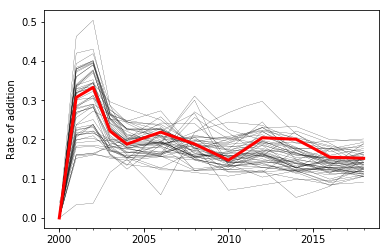

In [21]:
zipcode = 60622

# plot license renewals
ax = plot_timeseries(rate_of_addition)
ax.set_ylabel('Rate of addition')
rate_of_addition.loc[:, zipcode].plot(ax=ax, lw=3, color='r')

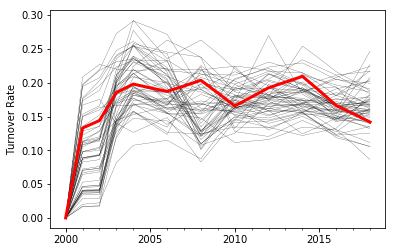

In [22]:
# plot license renewals
ax = plot_timeseries(turnover_rate)
ax.set_ylabel('Turnover Rate')
turnover_rate.loc[:, zipcode].plot(ax=ax, lw=3, color='r')

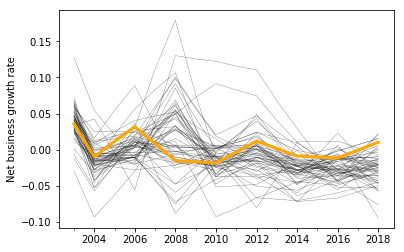

In [37]:
# plot license renewals
selected = net_business_growth[net_business_growth.index>='2003-01-01']
ax = plot_timeseries(selected)
ax.set_ylabel('Net business growth rate')
selected.loc[:, zipcode].plot(ax=ax, lw=3, color='orange', label='60622')

fig = plt.gcf()
fig.savefig('business_growth_rate.png')

In [38]:
# normalize and detrend realestate value data
detrended_mvalfah = detrend(normalize_by_baseline(mvalfah.resample('1Y').mean(), baseline_length=1))

In [39]:
# evaluate change over <nshift> years
nshift = 1
derivatives = detrended_mvalfah.diff(nshift) / nshift

In [162]:
# resample
#freq = '2Y'
#derivatives = derivatives.resample(freq, label='left', closed='right', loffset='1Y').mean()

In [40]:
def evaluate_correlation(X, Y, offset=0, freq='1Y'):
    window = X.index.shift(offset, freq)
    available = window <= Y.index.max()
    Y = Y.loc[window[available], :]
    R, pval = pearsonr(X[available].values.flatten(), Y.values.flatten())
    return R, pval

In [49]:
X = net_business_growth[net_business_growth.index >= '2005']
Y = derivatives

offsets = np.arange(-5, 15)
rr, pp = list(zip(*[evaluate_correlation(X, Y, offset, freq) for offset in offsets]))

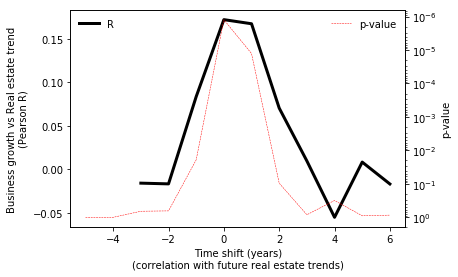

In [50]:
fig, ax = plt.subplots()
ax.set_xlabel('Time shift (years)\n(correlation with future real estate trends)')

ax.plot(offsets, rr, '-k', lw=3, label='R')
ax.set_ylabel('Business growth vs Real estate trend\n(Pearson R)')

ax2 = ax.twinx()
ax2.plot(offsets, pp, '--r', lw=0.5, label='p-value')
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.set_ylabel('p-value')
ax.legend(loc=2, frameon=False)
ax2.legend(loc=1, frameon=False)

In [51]:
def evaluate_correlation_individual(X, Y, offset=0):
    window = X.index.shift(offset)
    available = window <= Y.index.max()
    Y = Y.loc[window[available], :]
    
    xx, yy = X[available], Y
    
    adict = {}
    for i, (xrow, yrow) in enumerate(zip(xx.values.T, yy.values.T)):    
        adict[xx.columns[i]] = pearsonr(xrow, yrow)
    df = pd.DataFrame.from_dict(adict, orient='index', columns=['R', 'P'])
    
    
    bonferoni = 0.05 / len(df)
    
    false_positive_rate = 0.1
    ind = (df.P <= (false_positive_rate * df.P.argsort() / len(df)))
    bh_threshold = df.P[ind].max()
    
    
    df['bonferoni'] = df.P <= bonferoni
    df['benjamini_hochberg'] = df.P <= bh_threshold
    
    return df, bonferoni,  bh_threshold

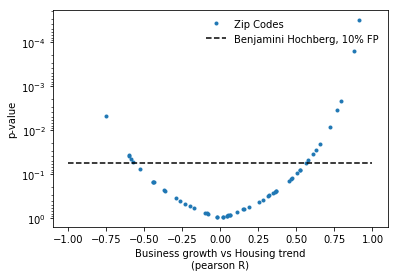

In [62]:
# check correlations for each zipcode
offset = 2
results, bonf, bh = evaluate_correlation_individual(X, Y, offset)
results = results.sort_values(by='P')

# volcano plot
fig, ax = plt.subplots()
ax.plot(results.R, results.P, '.', label='Zip Codes')
ax.set_yscale('log')
ax.invert_yaxis()
#ax.plot([-1., 1.], [bonf, bonf], '--r', label='Bonferroni')
ax.plot([-1., 1.], [bh, bh], '--k', label='Benjamini Hochberg, 10% FP')
ax.set_xlabel('Business growth vs Housing trend\n(pearson R)')
ax.set_ylabel('p-value')
ax.legend(loc=1, frameon=False)

fig.savefig('individual_correlations.png')

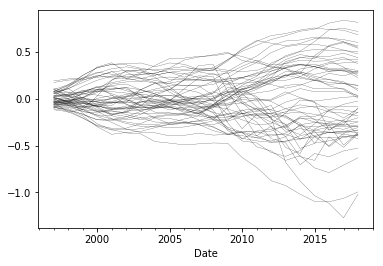

In [187]:
_ = plot_timeseries(detrended_mvalfah)

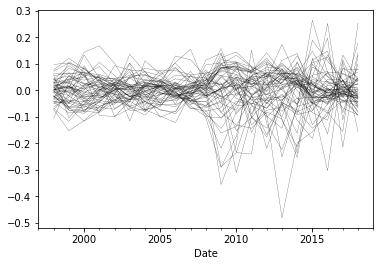

In [188]:
_ = plot_timeseries(derivatives)

In [769]:
top_codes = license_history.groupby('CODE')['CODE'].count().sort_values(ascending=False)

Index(['Limited Business License', 'Retail Food Establishment',
       'Regulated Business License', 'Home Occupation', 'Special Event Food',
       'Tobacco', 'Home Repair',
       'Consumption on Premises - Incidental Activity', 'Peddler, non-food',
       'Peddler License',
       ...
       'Navy Pier Vendor (Food) 30 Day', 'Tobacco Vending Machine Operator',
       'Repossessor Class A', 'Transportation Network Provider',
       'Class A - Indoor Special Event', 'Liquor Airport Pushcart License',
       'Sports Facilities Authority License', 'Guard Dog Service',
       'Airport Pushcart Liquor Midway - Class A', 'Repossessor Class B'],
      dtype='object', name='CODE', length=135)

In [775]:
pd.merge(top_codes, )

ValueError: can not merge DataFrame with instance of type <class 'pandas.core.series.Series'>

In [780]:
x=

In [786]:
#top_codes = top_codes.to_frame()
top_codes['DESCRIPTION'] = top_codes.index.map(codebook.get)

In [ ]:
"""


"""

In [221]:
codes = codebook.values()

In [224]:
for code in codes:
    if 'music' in code.lower():
        print(code)

Music and Dance


In [229]:
for act in activitybook.values():
    if 'mus' in act.lower():
        print(act)

In [254]:
is_repair = lambda x: sum([string in str(x).lower() for string in ['repair', 'service', 'tuning']])
is_music = lambda x: sum([string in str(x).lower() for string in ['piano', 'music', 'instrument']])

ind = locations.DBA.apply(lambda x: is_music(x) > 0 and is_repair(x) > 0)

In [255]:
loc = locations[ind]

In [256]:
loc.join(location_history)[['DBA', 'START', 'END', 'ACTIVE']]

DBA  \
ACCOUNT_ID SITE_ID                                                      
47618      1                                    CHICAGO MUSIC SERVICE   
56418      1                                      LUKAS PIANO SERVICE   
59851      3                                    INFANTE PIANO SERVICE   
63535      2                   MID TOWN INSTRUMENTS RENTALS & REPAIRS   
223272     1                           J & B MUSIC STORE & T V REPAIR   
255204     1        JUGGANOTT STUDIOS MUSIC SALES & PRINTING SERVI...   
277719     1                                     CLASSIC PIANO REPAIR   
           2                                     CLASSIC PIANO REPAIR   
332633     1                                     BRIANT PIANO SERVICE   
345568     1                                 Worldwide Music Services   
347763     1                                    YOUNGER PIANO SERVICE   
348020     1                                  Andrepont Piano Service   
361645     1                                         BB PIANO SERVICE   
363544     2        PRESTIGE PARKING SERVICES OF CHICAGO/REDHEAD P...   
379247     1                                     LORANG PIANO SERVICE   
           2                                     LORANG PIANO SERVICE   
390551     1                   Century Mallet Instrument Service, LLC   

                        START                        END  ACTIVE  
ACCOUNT_ID SITE_ID                                                
47618      1       2002-02-16 2004-02-15 00:00:00.000000   False  
56418      1       2002-02-16 2017-04-15 00:00:00.000000   False  
59851      3       2004-01-29 2007-05-17 00:00:00.000000   False  
63535      2       2002-02-16 2018-11-12 12:09:55.059304    True  
223272     1       2002-01-18 2003-11-15 00:00:00.000000   False  
255204     1       2003-01-03 2004-02-15 00:00:00.000000   False  
277719     1       2004-10-19 2004-10-19 00:00:00.000000   False  
           2       2005-11-15 2010-09-15 00:00:00.000000   False  
332633     1       2008-06-10 2008-10-15 00:00:00.000000   False  
345568     1       2009-07-17 2012-05-15 00:00:00.000000   False  
347763     1       2009-10-01 2013-02-15 00:00:00.000000   False  
348020     1       2009-10-13 2011-11-15 00:00:00.000000   False  
361645     1       2012-12-29 2013-05-15 00:00:00.000000   False  
363544     2       2011-06-30 2014-06-30 00:00:00.000000   False  
379247     1       2013-03-22 2015-04-15 00:00:00.000000   False  
           2       2015-03-10 2018-11-12 12:09:55.059304    True  
390551     1       2014-06-23 2018-11-12 12:09:55.059304    True

In [336]:
active_locations = locations.join(location_history[location_history.ACTIVE==True], how='inner')

In [337]:
counts = active_locations.groupby(level=0).count()['NAME']

multilocation = counts[counts > 10]

In [338]:
current_value = mvalfah.loc['2018-01-31']

In [339]:
current_value.name = 'VALUE'

In [340]:
active_locations = active_locations.join(multilocation, how='inner', lsuffix='str')[['NAMEstr', 'ZIP']]

In [342]:
active_locations_values = active_locations.join(current_value, on='ZIP')

In [353]:
meanvals = active_locations_values.groupby(level=0)['VALUE'].mean()

In [354]:
names = active_locations_values.groupby(level=0)['NAMEstr'].first()

In [375]:
ranking = meanvals.sort_values(ascending=True)
for ind in ranking.index[:10]:
    print(names[ind])

FLOOD BROS DISPOSAL CO.
BASTE FINANCIAL SERVICES, INC.
DIAMOND WASTE & RECYCLING CORP.
FALCON HOLDINGS, LLC
THE UNIVERSITY OF CHICAGO
FASHION GALLERY, INC.
ADVANCE STORES COMPANY, INCORPORATED
DG RETAIL, LLC
PALETERIA AZTECA INC.
FOOT LOCKER RETAIL, INC.


In [376]:
for ind in ranking.index[-10:][::-1]:
    print(names[ind])

DIAMOND PARKING SERVICE INC.
MASTER VALET PARKING LLC
ABC PARKING CORP.
CHITOWN MANAGEMENT, LLC ROSCOE VILLAGE GUESTHOUSE
PIONEER PARKING, INC.
SONDER USA INC.
LEVY PREMIUM FOODSERVICE LIMITED PARTNERSHIP
VALET PARKING PROFESSIONALS LLC
VALET PARKING AUTHORITY LIMITED
URBAN OUTFITTERS WEST LLC


In [798]:
location_history = location_history[location_history.CODES.apply(lambda x: '1006' in x)]

,,ACTIVE,START,END,LIFESPAN,ORIGINAL,CONTINUOUS,NUM_LICENSES,ACTIVITIES,CODES
ACCOUNT_ID,SITE_ID,,,,,,,,,
18557,4,False,1999-02-16,2003-11-14 00:00:00.000000,1732 days 00:00:00,True,True,1,"(775,)","(1006,)"
37502,1,False,1999-02-16,2004-02-15 00:00:00.000000,1825 days 00:00:00,True,True,1,(),"(1607,)"
82000,1,False,1999-02-16,2004-02-15 00:00:00.000000,1805 days 00:00:00,True,True,3,(),"(1008, 1009, 1010)"
39496,1,False,1999-02-16,2013-02-15 00:00:00.000000,5065 days 00:00:00,True,True,2,"(769,)","(1603, 4406)"
32279,1,False,1999-02-16,2003-02-15 00:00:00.000000,1460 days 00:00:00,True,True,1,(),"(1010,)"
41096,1,False,1999-02-16,2003-02-15 00:00:00.000000,1460 days 00:00:00,True,True,1,(),"(1010,)"
50835,3,False,1999-05-16,2006-02-15 00:00:00.000000,2467 days 00:00:00,True,True,2,"(638, 775)","(1475, 1006)"
40818,1,False,1999-08-16,2002-08-15 00:00:00.000000,1095 days 00:00:00,True,True,1,(),"(1010,)"
38565,1,False,1999-08-16,2004-08-15 00:00:00.000000,1826 days 00:00:00,True,True,1,(),"(1012,)"


In [ ]:
"""
1010 	96562 	Limited Business License
1006 	34033 	Retail Food Establishment
4404 	13785 	Regulated Business License
1012 	11125 	Home Occupation
1329 	10733 	Special Event Food
1781 	9845 	Tobacco
1011 	6471 	Home Repair
1475 	4980 	Consumption on Premises - Incidental Activity
1604 	4446 	Peddler, non-food
4406 	4141 	Peddler License
8340 	2638 	Motor Vehicle Services License
1009 	2207 	Manufacturing Establishments
1474 	2161 	Package Goods
1476 	2145 	Special Event Liquor
1569 	2111 	Motor Vehicle Repair : Engine Only (Class II)
1008 	2101 	Hazardous Materials
1605 	1973 	Street Performer
1470 	1906 	Tavern
2101 	1804 	Valet Parking Operator
1007 	1680 	Wholesale Food Establishment
1603 	1638 	Peddler, food (fruits and vegtables only)
1020 	1603 	Residential Real Estate Developer
1525 	1559 	Massage Therapist
1003 	1424 	Commercial Garage
1050 	1368 	Public Place of Amusement
1023 	1362 	Children's Services Facility License
"""

In [ ]:
from modules.tables import datframe_to_png

# save table of most common license codes
license_codes = licenses.groupby('LICENSE CODE')['LICENSE DESCRIPTION'].agg(['count', 'first']).sort_values('count', ascending=False)
top10_license_codes = license_codes.iloc[:10]
top10_license_codes.rename({'count': 'NUM. LICENSES', 'first': 'LICENSE TYPE'}, axis=1, inplace=True)
top10_license_codes.reset_index(inplace=True)
top10_license_codes.index = range(1, len(top10_license_codes)+1)
datframe_to_png(top10_license_codes, filename='top10', outputdir='../tables')

<img src="../tables/top10.png" >

# Preprocessing

In [59]:
# identify newly issued licenses
new = licenses[np.logical_and(licenses['APPLICATION TYPE']=='ISSUE', licenses['LICENSE STATUS'] == 'AAI')]
renewed = licenses[np.logical_and(licenses['APPLICATION TYPE']=='RENEW', licenses['LICENSE STATUS'] == 'AAI')]
cancelled = licenses[licenses['LICENSE STATUS'].isin(['AAC', 'REV'])]

# compute number of additions/renewals per zip code
criteria = ['DATE ISSUED', 'ZIP CODE', 'LICENSE CODE']
num_additions = new.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
num_renewals = renewed.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
turnover = cancelled.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()

# compute annual additions/renewals per zip code
annual_additions = num_additions.resample('1Y', axis=0).sum()
annual_renewals = num_renewals.resample('1Y', axis=0).sum()
annual_turnover = turnover.resample('1Y', axis=0).sum()

# impute 2011/2012 due to licensing reform
annual_additions = annual_additions.drop(annual_renewals.loc['2011'].index)
annual_additions = annual_additions.drop(annual_renewals.loc['2012'].index)
annual_additions = annual_additions.resample('1Y', axis=0).interpolate()
annual_renewals = annual_renewals.drop(annual_renewals.loc['2011'].index)
annual_renewals = annual_renewals.drop(annual_renewals.loc['2012'].index)
annual_renewals = annual_renewals.resample('1Y', axis=0).interpolate()
annual_turnover = annual_turnover.drop(annual_turnover.loc['2011'].index)
annual_turnover = annual_turnover.drop(annual_turnover.loc['2012'].index)
annual_turnover = annual_turnover.resample('1Y', axis=0).interpolate()

# smooth renewals (some are bi-annual)
annual_renewals = annual_renewals.apply(savgol_filter, args=(3, 1))

/Users/Sebi/.virtualenvs/incubator/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/Users/Sebi/.virtualenvs/incubator/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


# Plot license addition/renewal/turnover timeseries

These are the rates of license additions, renewal, and turnover for each zipcode over the past two decades.

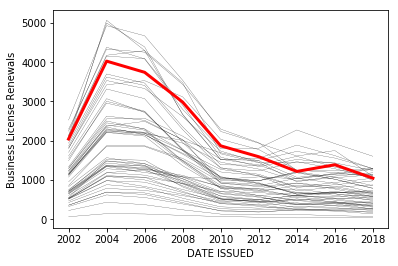

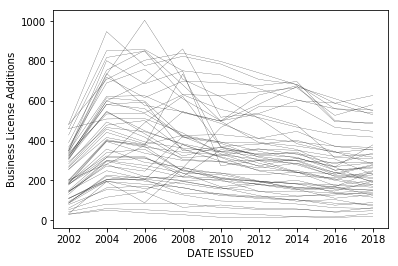

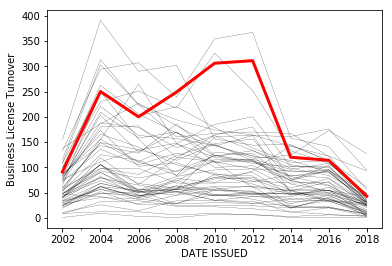

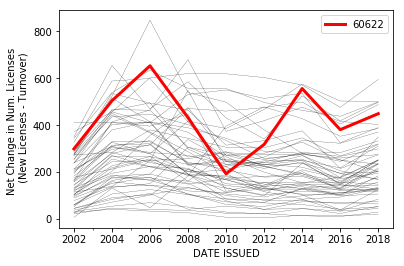

In [61]:
# compute annual additions/renewals per zip code
freq = '2Y'
addition_ts = annual_additions.resample(freq, axis=0).sum()
renewal_ts = annual_renewals.resample(freq, axis=0).sum()
turnover_ts = annual_turnover.resample(freq, axis=0).sum()

# plot license renewals
ax = plot_timeseries(renewal_ts)
ax.set_ylabel('Business License Renewals')
renewal_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license additions
ax = plot_timeseries(addition_ts)
ax.set_ylabel('Business License Additions')
#addition_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')
fig = plt.gcf()
fig.savefig('additions.png')

# plot license turnover
ax = plot_timeseries(turnover_ts)
ax.set_ylabel('Business License Turnover')
turnover_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license growth rate
net_change = (addition_ts-turnover_ts)
ax = plot_timeseries(net_change)
ax.set_ylabel('Net Change in Num. Licenses \n (New Licenses - Turnover)')
ax.set_xlabel('Year')
net_change.loc[:, 60622].plot(ax=ax, lw=3, color='r', label='60622')
ax.legend(handles=[red_line])

# Simple correlation between property values and licensing rates

There is a weak correlation between the annual net change in business licenses and the relative property value.

In [86]:
# normalize and detrend realestate value data
detrended_mvalfah = detrend(normalize_by_baseline(mvalfah, baseline_length=1))


X = net_change
Y = detrended_mvalfah.resample('1Y').mean().loc[X.index, :]
pearsonr(X.values.flatten(), Y.values.flatten())

(0.43210541048175194, 2.415617873086622e-24)